# Functional model

In [787]:
#TODO: printing methods
#TODO: use Enums (?)
#TODO function to link parameters across populations (generate only once)
#TODO to_dataframeobj()
#TODO use recalculate_size ?
#TODO return self in population methods for chaining
#TODO scipy truncated normal is too slow

In [788]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1

from copy import copy
from warnings import warn
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from numpy import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
from scipy.stats import truncnorm
import scipy
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
scipy.stats.rv_continuous.random_state = seed
random.seed(seed)

In [789]:
#helper functions

def truncatednormal(xmin, xmax, pmsigma=3, shape=1):
    '''
    Samples values from a truncated normal distribution 
    It has lower limit xmin and upper limit xmax
    It is located at the mean of the lower and upper limits
    And its scale is determined by: if it were not truncated it would have a pmsigma amount of standard deviations between the mean and the limits
    '''
    
    # user input
    myclip_a = xmin
    myclip_b = xmax
    my_mean = (xmax+xmin)/2
    my_std = (xmax-xmin)/(2*pmsigma)

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm.rvs(a, b, loc=my_mean, scale=my_std, size=shape)

In [790]:
from types import MethodType

class Population:
    def __init__(self, size=10000, title=''):
        
        self.title = title
        self.size = size
        
        self.parameter_generators = {}
        self.parameters = {}
        self.function_generators = {}
        
        self.visualscores = None
        self.symptomscores_noerror = None
        self.symptomscores = None
        
    #Data generation methods

    def set_parameter_generator(self, paramname, func, paramtype):
        '''
        func must be a numpy function with the "shape" argument of the numpy function as the only argument to func
        paramtype must be either "population", "person", or "day"
        '''
        if func.__code__.co_varnames != ('shape',):
            raise ValueError("The function for parameter generation should only have 'shape' as an argument. "+
                             "Currently, it's arguments are: "
                            +", ".join(["'"+str(arg)+"'" for arg in func.__code__.co_varnames]))
        
        if paramtype == 'population':
            shape = (1,)
        elif paramtype == 'person':
            shape = (self.size, 1)
        elif paramtype == 'day':
            shape = (self.size, NDAYS)
        self.parameter_generators[paramname] = lambda: func(shape)
    def generate_parameters(self):
        '''generates all parameters
        if population was already generated, is resets the scores (since they were based on previous parameters)
        '''
        #generate
        for paramname in self.parameter_generators.keys():
            self.parameters[paramname] = self.parameter_generators[paramname]()
        #reset
        self.visualscores = None
        self.symptomscores_noerror = None
        self.symptomscores = None        
    
    def set_score_generator(self, scorename, func):
        '''scorename is either visualscore, symptomscore_noerror, or symptomscore'''
        self.function_generators[scorename] = func
    def generate_from_score_generator(self, generatorname):
        '''generatorname is either visualscore, symptomscore_noerror, or error'''
        func = self.function_generators[generatorname]
        paramnames = func.__code__.co_varnames
        paramvals = []
        for paramname in paramnames:
            #reserved parameters
            if paramname == 't':
                paramvals.append(np.arange(NDAYS))
            elif paramname == 'f':
                paramvals.append(self.visualscores)
            elif paramname == 's':
                paramvals.append(self.symptomscores_noerror)
            #custom parameters
            else:
                paramvals.append(self.parameters[paramname])
        return func(*paramvals)
    
    def generate(self, generate_parameters=True):
        if generate_parameters: self.generate_parameters()
        
        self.visualscores = self.generate_from_score_generator('visualscore')
        minscore = np.min(self.visualscores)
        if minscore < FMIN: 
            warn("visual score in {} has min={}, which is below FMIN={}".format(self.title, minscore, FMIN))
        self.symptomscores_noerror = self.generate_from_score_generator('symptomscore_noerror')
        self.symptomscores = self.generate_from_score_generator('symptomscore')
        minscore = np.min(self.symptomscores)
        if minscore < SMIN: 
            warn("symptom score in {} has  min={}, which is below SMIN={}".format(self.title, minscore, SMIN))
            
        #if all parameters are 'population', the generation process will only have created a single row
        #so, repeat that row 'self.size' times to create the full matrix
        if self.visualscores.shape != (self.size, NDAYS):
            self.visualscores = np.broadcast_to(self.visualscores, (self.size, NDAYS))
        if self.symptomscores_noerror.shape != (self.size, NDAYS):
            self.symptomscores_noerror = np.broadcast_to(self.symptomscores_noerror, (self.size, NDAYS))
        if self.symptomscores.shape != (self.size, NDAYS):
            self.symptomscores = np.broadcast_to(self.symptomscores, (self.size, NDAYS))
    
    #Non-data-generation methods
    
    def recalculate_size(self):
        #TODO try-catch for if not generated yet
        self.size = self.visualscores.shape[0]
        
    def copy(self, newtitle=None, addtitle=None):
        newpop = copy(self) #python shallow copy
        if newtitle is not None:
            newpop.title = newtitle
        if addtitle is not None:
            newpop.title += ' '+addtitle
        newpop.parameter_generators = copy(self.parameter_generators)
        newpop.function_generators = copy(self.function_generators)
        return newpop
    
    def double(self, newtitle1=None, addtitle1=None, newtitle2=None, addtitle2=None):
        newpop2 = self.copy(newtitle=newtitle2, addtitle=addtitle2)
        newpop1 = self
        if newtitle1 is not None:
            newpop1.title = newtitle1
        if addtitle1 is not None:
            newpop1.title += ' '+addtitle1
        return newpop1, newpop2
    
    #removing outliers #TODO should this be changing the population or creating a copy?
    def filter(self, recovered_symptom_score=SMIN, firstday=FIRSTVISIT, lastday=NDAYS):
        persons_recovered_early = np.any(self.symptomscores[:,:firstday] <= recovered_symptom_score, axis=1)
        persons_recovered_late = np.min(self.symptomscores[:,:lastday], axis=1) > recovered_symptom_score
        persons_excluded = np.logical_or(persons_recovered_early, persons_recovered_late)
        persons_included = np.logical_not(persons_excluded)

        self.visualscores = self.visualscores[persons_included]
        self.symptomscores_noerror = self.symptomscores_noerror[persons_included]
        self.symptomscores = self.symptomscores[persons_included]
        self.size = self.visualscores.shape[0]
    
    #plotting
    def plot(self, ax, ndays=None, npersons=None, score='symptom', viztype='lines'):
        #score is either 'symptom', 'visual', or 'symptom no error'
        #viztype is either 'lines', 'points', or 'both'
        
        if ndays is None: ndays=NDAYS
        if npersons is None: npersons=self.size
        
        if score=='visual':
            scores = self.visualscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='visual score')
        if score=='symptom no error':
            scores = self.symptomscores_noerror[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score without error')
        if score=='symptom':
            scores = self.symptomscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score')
        
        colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']] #list of 10 rgba colors
        if viztype=='lines' or viztype=='both':
            days = np.tile(np.arange(ndays), npersons).reshape((npersons, ndays))
            points = np.stack([days, scores], axis=2)
            ax.add_collection(LineCollection(points, colors=colors))
            ax.autoscale()
        if viztype=='points' or viztype=='both':
            days = np.tile(np.arange(ndays), npersons)
            edgecolors = np.repeat(colors[:npersons], ndays, axis=0)
            ax.scatter(days, scores.flatten(), facecolors='none', edgecolors=edgecolors)
            ax.autoscale()

# Population generation

In [791]:
# Various functions to create populations

def get_default_pop(size=10000):
    pop = Population(size, 'default pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visualscore', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'person')
    gen_f0 = lambda shape: 16
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptomscore', gen_error_mult)
    gen_C = lambda shape: 1
    pop.set_parameter_generator('C', gen_C, 'day')

    return pop

def get_poster_pop(size=10000):
    pop = Population(size, 'poster pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visualscore', gen_visualscores)
    gen_r = lambda shape: 2
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: np.random.randint(14, 18+1, size=shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a,s0: np.maximum(a*f+s0, SMIN)
    pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')
    gen_s0 = lambda shape: np.random.normal(6, 2, size=shape)
    pop.set_parameter_generator('s0', gen_s0, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptomscore', gen_error_mult)
    gen_C = lambda shape: 1 + np.random.choice([-1, 1], size=shape)*(np.random.randint(0, 30, size=shape)/100)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_prevsim_pop(size=10):
    pop = Population(size, 'previous simulation - basic pop')
    
    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visualscore', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: truncatednormal(14, 18, 3, shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
    gen_a = lambda shape: random.choice([1, 2, 3], shape)
    pop.set_parameter_generator('a', gen_a, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptomscore', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.8, 1.2, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_linpop(size=10000):
    pop = get_default_pop(size)
    pop.title = 'linear population with multiplicative error'
    
    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptomscore', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.7, 1.3, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_exppop(size=10000):
    pop = get_linpop(size)
    pop.title = 'exponential population with multiplicative error'
    
    #symptom score no error
    gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
    pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
    gen_B = lambda shape: np.full(shape=shape, fill_value=1.5)
    pop.set_parameter_generator('B', gen_B, 'population')
    
    return pop

In [795]:
pop_with_visual_score = Population(10000)
gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
pop_with_visual_score.set_score_generator('visualscore', gen_visualscores)
gen_r = lambda shape: truncatednormal(1/15, 31/15, 3, shape)
gen_f0 = lambda shape: truncatednormal(14, 15, 3, shape)
pop_with_visual_score.set_parameter_generator('r', gen_r, 'person')
pop_with_visual_score.set_parameter_generator('f0', gen_f0, 'person')

linear_pop = pop_with_visual_score.copy(newtitle='linear')
gen_symptomscores = lambda f,a: a*(f-FMIN)
linear_pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
gen_a = lambda shape: 1
linear_pop.set_parameter_generator('a', gen_a, 'population')

exponential_pop = linear_pop.copy(newtitle='exponential')
gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
exponential_pop.set_score_generator('symptomscore_noerror', gen_symptomscores)
exponential_pop.set_parameter_generator('a', gen_a, 'population')

B = 1.5
exponential_quick_pop, exponential_slow_pop = exponential_pop.double(addtitle1='quick', addtitle2='slow')
exponential_quick_pop.set_parameter_generator('B', lambda shape: B, 'population')
exponential_slow_pop.set_parameter_generator('B', lambda shape: 1/B, 'population')

gen_error_mul = lambda s,C: s*C
gen_C_mul = lambda shape: truncatednormal(0.7, 1.3, 3, shape)
gen_error_add = lambda s,C: np.maximum(s+C, SMIN)
gen_C_add = lambda shape: truncatednormal(-1, 1, 3, shape)


pops_noerror = [linear_pop, exponential_quick_pop, exponential_slow_pop]
pops_mulerror = []
pops_adderror = []

for i in range(ncols):
    pop_mul, pop_add = pops_noerror[i].double(addtitle1='multiplicative error', addtitle2='additive error')
    
    pop_mul.set_score_generator('symptomscore', gen_error_mul)
    pop_mul.set_parameter_generator('C', gen_C_mul, 'day')
    pop_mul.generate()
    pops_mulerror.append(pop_mul)
    
    pop_add.set_score_generator('symptomscore', gen_error_add)
    pop_add.set_parameter_generator('C', gen_C_add, 'day')
    pop_add.generate()
    pops_adderror.append(pop_add)

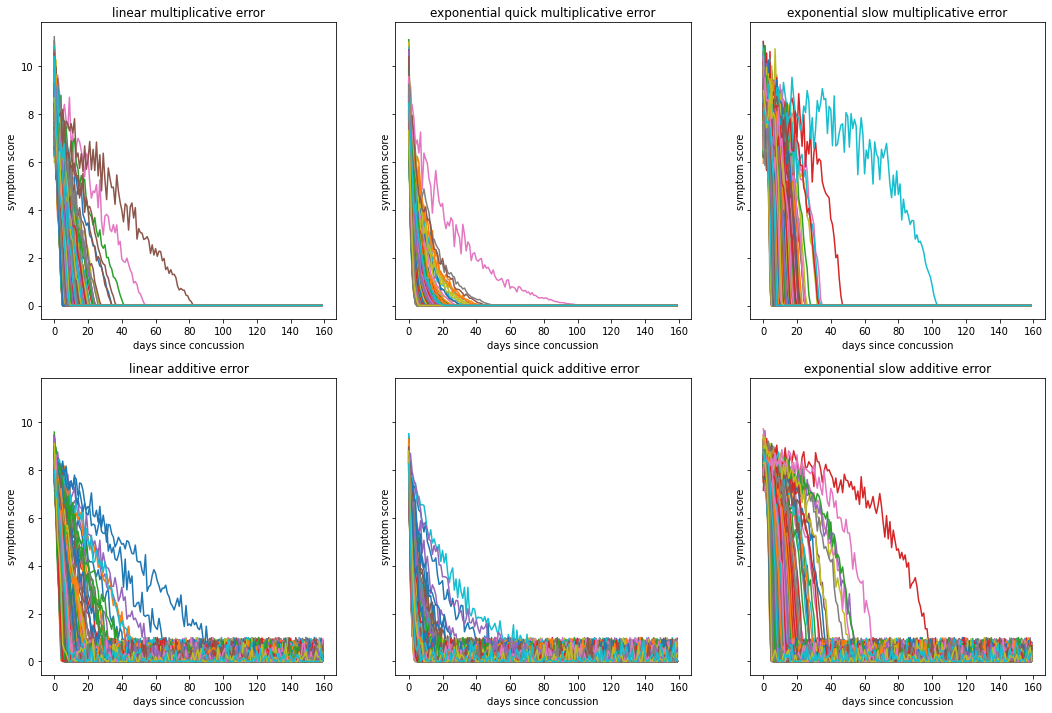

In [798]:
ncols = len(pops_noerror)
nrows = len([pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, sharey=True)
npersons=1000
ndays=None

for i in range(ncols):
    pops_mulerror[i].plot(axes[0, i], npersons=npersons, ndays=ndays)
    pops_adderror[i].plot(axes[1, i], npersons=npersons, ndays=ndays)
    
plt.show()

In [778]:
%timeit truncatednormal(0, 1, 3, 10000)
%timeit np.random.normal(*uniform_to_normal((0, 1), 3), 10000)

215 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
691 µs ± 59.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Study

In [617]:
#TODO not only first dip, but multiple consecutive days
#TODO explain that reshape(-1,1) makes rows into columns

class Study:
    
    def __init__(self, title='', sample_args=[7, 14, 28], smilescore='symptomscore'):
        '''
        Sample args that are integers are interpreted as a fixed day
        Sample args between 0 and 1 (exclusive) are interpreted as a percentage with which to use SMILE, based on the first fixed day
        Sample args that do not fit the above criteria are ignored
        smilescore determines which score the milestone_ratios will be based on (can be symptomscore, visualscore, or symptomscore_noerror)
        '''
        
        self.title=title
        self.smilescore=smilescore
        
        sample_args = np.array(sample_args)
        self.fixed_days = sample_args[sample_args == sample_args.astype(int)].astype(int)
        self.milestone_ratios = sample_args[(0 < sample_args) | (sample_args < 1)]
        
        if self.fixed_days.size==0: 
            raise Exception("No fixed days in sample_args, which were {}".format(sample_args))
        
        if np.max(self.fixed_days) >= NDAYS:
            raise Exception("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, LASTVISIT))
        if np.max(self.fixed_days) > LASTVISIT:
            warn("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, LASTVISIT))
        if np.min(self.fixed_days) < FIRSTVISIT:
            warn("There is a fixed sample day in {} that is earlier than the FIRSTVISIT of {}".format(self.fixed_days, FIRSTVISIT))
        
    def sample(population, filter=True):
        if filter: population = deepcopy(population).filter()
                 
        # MILESTONES        
        
        if self.smilescore == 'visualscore':
            smilescores = population.visualscores
        elif self.smilescore == 'symptomscore':
            smilescores = population.symptomscores
        elif self.smilescore == 'symptomscore_noerror':
            smilescores = population.symptomscores_noerror
                 
        index = np.min(self.fixed_days) #day which milestone_ratios are based on
        scores_at_index = smilescores[:, index].reshape(-1, 1) #reshape to be vertical
        smile_vals = scores_at_index*self.milestone_ratios #The score values to reach. Each row is a person, each column is a milestone
        
        milestone_days = np.empty_like(smile_vals) #will hold the day each milestone_ratio is reached for each person
        for milestone_col in range(smile_vals.shape[1]):
            milestone_vals = smile_vals[:,milestone_col].reshape(-1, 1)
            milestone_days[:,milestone_col] = np.argmax(smilescores <= milestone_vals, axis=1).astype(int) #the day at which the milestone is reached for each person
        #careful: values of 0 in milestone_days might represent 'day 0' or might represent 'never reached milestone'
        
        #Sample at those days
        milestone_visualscores = np.take_along_axis(population.visualscores, milestone_days, axis=1)
        milestone_symptomscores = np.take_along_axis(population.symptomscores, milestone_days, axis=1)
        milestone_symptomscores_noerror = np.take_along_axis(population.symptomscores_noerror, milestone_days, axis=1)
        #replace the 'fake' days and scores with NaN
        notFake = (scores_at_milestones <= smile_vals)
        milestone_days = np.where(notFake, milestone_days, np.nan)
        milestone_visualscores = np.where(notFake, milestone_visualscores, np.nan)
        milestone_symptomscores = np.where(notFake, milestone_symptomscores, np.nan)
        milestone_symptomscores_noerror = np.where(notFake, milestone_symptomscores_noerror, np.nan)
        
        # FIXED
        
        fixed_days = np.tile(self.fixed_days, (smilescores.shape[0],1)) #same shape as milestone_days
        fixed_visualscores = np.take_along_axis(population.visualscores, fixed_days, axis=1)
        fixed_symptomscores = np.take_along_axis(population.symptomscores, fixed_days, axis=1)
        fixed_symptomscores_noerror = np.take_along_axis(population.symptomscores_noerror, fixed_days, axis=1)
        
        # COMBINE fixed and milestones
        
        self.sample_days = np.concatenate([self.fixed_days, self.milestone_days], axis=1)
        self.sample_visualscores = np.concatenate([self.fixed_visualscores, self.milestone_visualscores], axis=1)
        self.sample_symptomscores = np.concatenate([self.fixed_symptomscores, self.milestone_symptomscores], axis=1)
        self.sample_symptomscores_noerror = np.concatenate([self.fixed_symptomscores_noerror, self.milestone_symptomscores_noerror], axis=1)
                 
    #TODO analyze method
                 
    #TODO compare_analysis classmethod